# 用 OpenSlide 读取 QPTIFF 中心区域（无 tifffile 回退）

固定路径：`/nfs5/yj/MIHC/dataset/KidneyCancer/NO2/11/Scan1/11_Scan1.qptiff`

说明：
- 仅使用 OpenSlide 读取并展示中心区域。
- OpenSlide 通常提供 RGB(A) 视图，这里拆分并展示 B/G/R 三个通道。
- 控制台输出使用分隔标记便于阅读；用 OpenCV 可视化每步。


In [18]:
print("_____")
print("[INFO] 环境与依赖导入")
print("_____")
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

try:
    import openslide
    has_openslide = True
except Exception as e:
    has_openslide = False
    print("_____")
    print("[ERROR] OpenSlide 导入失败:", e)
    print("[HINT] 请安装系统库 libopenslide 以及 Python 包 openslide-python")
    print("_____")

print("_____")
print("[INFO] has_openslide =", has_openslide)
print("_____")


_____
[INFO] 环境与依赖导入
_____
_____
[INFO] has_openslide = True
_____


In [19]:
# 固定路径与读取配置
QPTIFF_PATH = "/nfs5/yj/MIHC/dataset/KidneyCancer/NO2/11/Scan1/11_Scan1.qptiff"
PATCH_SIZE = 1024  # 在所选层级读取的区域尺寸
LEVEL = 0  # 手动指定层级；None 表示自动选择

print("_____")
print("[INFO] 目标文件路径:", QPTIFF_PATH)
print("[INFO] 读取区域尺寸:", PATCH_SIZE)
print("[INFO] 选择层级:", LEVEL)
print("_____")

if not os.path.exists(QPTIFF_PATH):
    print("_____")
    print("[ERROR] 文件不存在——请检查路径。")
    print("_____")
    raise FileNotFoundError(QPTIFF_PATH)


_____
[INFO] 目标文件路径: /nfs5/yj/MIHC/dataset/KidneyCancer/NO2/11/Scan1/11_Scan1.qptiff
[INFO] 读取区域尺寸: 1024
[INFO] 选择层级: 0
_____


In [20]:
def choose_level(slide, target_downsample=4.0):
    """
    选择与目标下采样因子最接近的层级。
    """
    downs = [float(d) for d in slide.level_downsamples]
    idx = int(np.argmin([abs(d - float(target_downsample)) for d in downs]))
    return idx

def show_rgb(img_rgb, title=""):
    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('off')
    plt.show()

def center_rect_on_thumbnail(thumb_rgb, w0, h0, loc_x, loc_y, patch_w, patch_h):
    th_h, th_w = thumb_rgb.shape[0], thumb_rgb.shape[1]
    scale_x = th_w / float(w0)
    scale_y = th_h / float(h0)
    rect_w = int(patch_w * scale_x)
    rect_h = int(patch_h * scale_y)
    rect_x = int(loc_x * scale_x)
    rect_y = int(loc_y * scale_y)
    overlay_bgr = cv2.cvtColor(thumb_rgb, cv2.COLOR_RGB2BGR)
    cv2.rectangle(overlay_bgr, (rect_x, rect_y), (rect_x+rect_w, rect_y+rect_h), (0,255,0), 2)
    return cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)


_____
[INFO] 使用 OpenSlide 读取中心区域
_____
[INFO] level0 尺寸: (34560, 50400)
[INFO] 层级数: 33
[INFO] 下采样因子: (1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0)
[INFO] 读取 level= 0  ds= 1.0
[INFO] 中心位置(level0): (16768, 24688) 区域尺寸(所选层级): (1024, 1024)


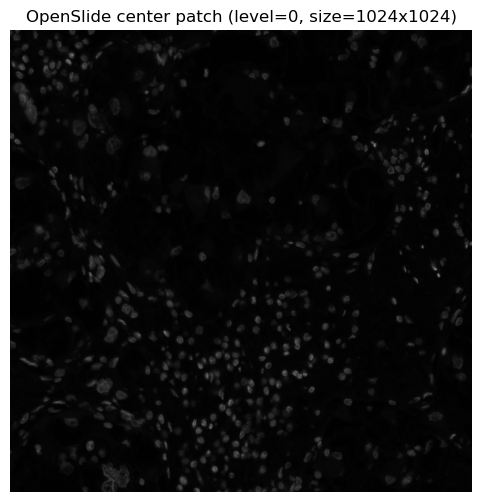

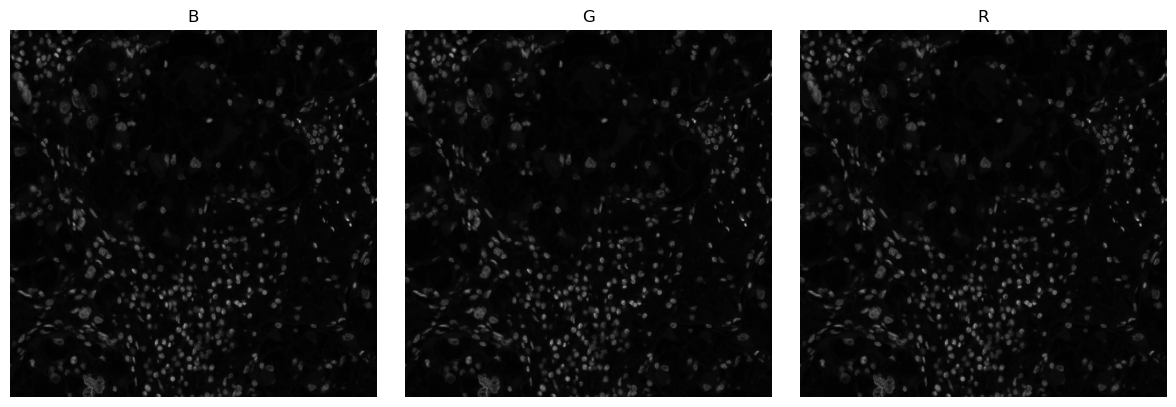

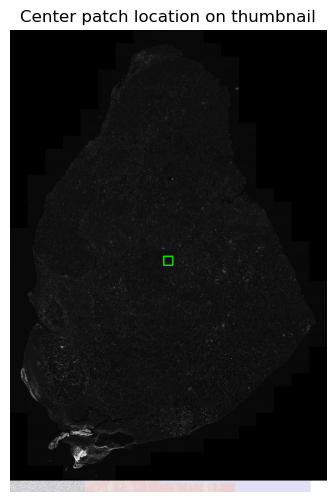

In [21]:
if not has_openslide:
    raise RuntimeError("OpenSlide 不可用，无法继续。")

print("_____")
print("[INFO] 使用 OpenSlide 读取中心区域")
print("_____")
slide = openslide.OpenSlide(QPTIFF_PATH)
w0, h0 = slide.dimensions
print("[INFO] level0 尺寸:", (w0, h0))
print("[INFO] 层级数:", slide.level_count)
print("[INFO] 下采样因子:", slide.level_downsamples)
level = LEVEL if LEVEL is not None else choose_level(slide, target_downsample=4.0)
if level < 0 or level >= slide.level_count:
    print("_____")
    print("[WARN] 指定层级越界，自动选择接近目标的层级。")
    print("_____")
    level = choose_level(slide, target_downsample=4.0)
ds = float(slide.level_downsamples[level])
patch_w = patch_h = int(PATCH_SIZE)
loc_x = int(max(0, w0/2.0 - (patch_w*ds)/2.0))
loc_y = int(max(0, h0/2.0 - (patch_h*ds)/2.0))
print("[INFO] 读取 level=", level, " ds=", ds)
print("[INFO] 中心位置(level0):", (loc_x, loc_y), "区域尺寸(所选层级):", (patch_w, patch_h))
region = slide.read_region((loc_x, loc_y), level, (patch_w, patch_h)).convert("RGB")
region_np = np.array(region)  # H, W, 3 (RGB)
show_rgb(region_np, title=f"OpenSlide center patch (level={level}, size={patch_w}x{patch_h})")

# 拆分通道（B/G/R）
rgb_bgr = cv2.cvtColor(region_np, cv2.COLOR_RGB2BGR)
chans = cv2.split(rgb_bgr)  # B, G, R
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ch in enumerate(chans):
    axes[i].imshow(ch, cmap='gray')
    axes[i].set_title(["B", "G", "R"][i])
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# 缩略图上叠加中心区域位置
thumb = slide.get_thumbnail((1024, 1024)).convert("RGB")
thumb_np = np.array(thumb)
overlay = center_rect_on_thumbnail(thumb_np, w0, h0, loc_x, loc_y, int(patch_w*ds), int(patch_h*ds))
show_rgb(overlay, title="Center patch location on thumbnail")
